In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../../src')

In [4]:
import cv2

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
from numpy.linalg import inv

from os import path as osp
from typing import (
    List, Tuple, Dict, Any,
    Optional, Sequence, Callable
)
from utils.optical_flow_numpy import optical_flow

from turbojpeg import TurboJPEG

import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [66]:
class ImageTransform:
    def __init__(self):
        self.transforms = A.Compose([    
            A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            A.Resize(*(480, 640)),
            ToTensorV2()
        ])

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=img)

In [67]:
transform = ImageTransform()

In [63]:

transform(image)

5.48 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
jpeg = TurboJPEG()

with open('/home/project/data/scans/scene0000_00/color/0.jpg', 'rb') as f:
    image = jpeg.decode(f.read(), 0, scaling_factor=(1, 2))


In [42]:
image.shape

(484, 648, 3)

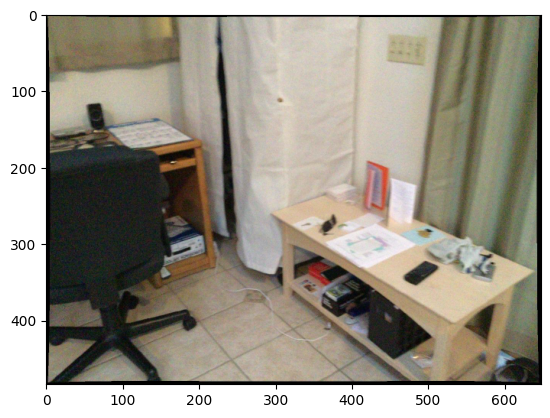

In [14]:
import matplotlib.pyplot as plt
plt.imshow(rgb_array)

In [12]:
"""Partially adapted from LoFTR code: https://github.com/zju3dv/LoFTR/tree/master/src/utils"""
"""Partially adapted from LoFTR code: https://github.com/zju3dv/LoFTR/tree/master/src/datasets/scannet.py"""


class JPEGReader:
    def __init__(self):
        self.reader = TurboJPEG()
        
    def __call__(self, path):
        with open(path, 'rb') as f:
            image = self.reader.decode(f.read(), 0)
        return image

    
class ImageTransform:
    def __init__(self, size):
        self.transforms = A.Compose([    
            A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            A.Resize(*size),
            ToTensorV2()
        ])

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=img)
    
    
def read_depth(path):
    depth = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    depth = depth / 1000
    return depth
    

def read_pose(path: np.ndarray):
    """ Read ScanNet's Camera2World pose and transform it to World2Camera.
    :param pose_w2c: (4, 4)
    """
    cam2world = np.loadtxt(path, delimiter=' ')
    world2cam = inv(cam2world)
    return world2cam


class ScanNetDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 npz_path: str,
                 intrinsics_path: str, 
                 mode: str=None,
                 mode_rgb_read: str='rgb',
                 size: Tuple[float, float]=(640, 480),
                 calculate_flow: bool=False,
                 **kwargs):
        """Manage one scene of ScanNet Dataset.
        :param root_dir: ScanNet root directory that contains scene folders.
        :param npz_path: {scene_id}.npz path. This contains image pair information of a scene.
        :param intrinsics_path: path to intrinsics.npz
        :param mode: options are ['train', 'val', 'test'].
        :param mode_rgb_read: read in 'gray' or 'rgb' mode
        :param size: the size of depth image
        :param calculate_flow: whether to calculate optical flow
        """
        super().__init__()
        self.root_dir = root_dir

        self.mode_rgb_read = mode_rgb_read
        self.size = size
        self.calculate_flow = calculate_flow
        
        with np.load(npz_path) as data:
            self.data_names = data['name']
        self.intrinsics = np.load(intrinsics_path)
            
        self.jpeg_reader = JPEGReader()
        self.rgb_transform = ImageTransform(size)
        
    def __len__(self):
        return len(self.data_names)
    
    def _read_abs_pose(self, scene_name, name):
        path = osp.join(self.root_dir, scene_name, 'pose', f'{name}.txt')
        return read_pose(path)

    def _compute_rel_pose(self, scene_name, name0, name1):
        pose0 = self._read_abs_pose(scene_name, name0)
        pose1 = self._read_abs_pose(scene_name, name1)
        return pose1 @ inv(pose0)

    def __getitem__(self, idx):
        data_name = self.data_names[idx]
        scene_name, scene_sub_name, stem_name_0, stem_name_1 = data_name
        pair_name  = f'{scene_name}_{scene_sub_name}_{stem_name_0}_{stem_name_1}'
        scene_name = f'scene{scene_name:04d}_{scene_sub_name:02d}'

        img_name0 = osp.join(self.root_dir, scene_name, 'color', f'{stem_name_0}.jpg')
        img_name1 = osp.join(self.root_dir, scene_name, 'color', f'{stem_name_1}.jpg')
        
        image0 = self.rgb_transform(self.jpeg_reader(img_name0))
        image1 = self.rgb_transform(self.jpeg_reader(img_name1))

        K_0 = K_1 = self.intrinsics[scene_name].reshape(3, 3).copy()
        T_0 = self._read_abs_pose(scene_name, stem_name_0)
        T_1 = self._read_abs_pose(scene_name, stem_name_1)
        
        if self.calculate_flow:
            depth0 = read_depth(osp.join(self.root_dir, scene_name, 'depth', f'{stem_name_0}.png'))
            flow_0to1, mask = optical_flow(depth0, T_0, T_1, K_0, K_1, mask=True, normalize=False)
        
        T_0to1 = torch.tensor(self._compute_rel_pose(scene_name, stem_name_0, stem_name_1),
                              dtype=torch.float32)

        data = {
            'image0': image0,  
            'image1': image1,
            'depth0': depth0.fl,
            'K0': K_0.astype('float32'),
            'K1': K_1.astype('float32'),
            'T_0to1': T_0to1,
            'T_0': torch.from_numpy(self._read_abs_pose(scene_name, stem_name_0,)).float(),
            'T_1': torch.from_numpy(self._read_abs_pose(scene_name, stem_name_1,)).float(),
            'dataset_name': 'ScanNet',
            'scene_id': scene_name,
            'pair_id': idx,
            'pair_name': pair_name,
            'pair_names': (osp.join(scene_name, 'color', f'{stem_name_0}.jpg'),
                           osp.join(scene_name, 'color', f'{stem_name_1}.jpg'))

            }
        
#         if self.calculate_flow:
#             data['flow_0to1'] = torch.from_numpy(flow_0to1.astype('float32'))
#             data['mask'] = torch.from_numpy(mask)
            
        return data

   



In [13]:
train_data = ScanNetDataset(
    root_dir='/home/project/data/scans/',
    npz_path='/home/project/code/data/scannet_splits/smart_sample_train_ft.npz',
    intrinsics_path='/home/project/ScanNet/scannet_indices/intrinsics.npz',
    calculate_flow=True
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True, pin_memory=False, num_workers=0)


In [7]:
data = next(iter(train_loader))

In [8]:
from utils.optical_flow_batch_torch import image2image
# data['depth0']

In [14]:
image2image(data['depth0'].float(), data['T_0'], data['T_1'], data['K0'], data['K1'])

RuntimeError: expected scalar type Double but found Float

In [10]:
data['depth0']

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 3.0350, 3.0350, 3.0050],
         [0.0000, 0.0000, 0.0000,  ..., 3.0350, 3.0350, 3.0050],
         [0.0000, 0.0000, 0.0000,  ..., 3.0350, 3.0350, 3.0050],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.5970, 1.5880, 1.5880],
         [0.0000, 0.0000, 0.0000,  ..., 1.5880, 1.5880, 1.5880],
         [0.0000, 0.0000, 0.0000,  ..., 1.5880, 1.5880, 1.5880]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [24]:
%%timeit
next(iter(train_loader)) #without flow

4.02 s ± 718 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
next(iter(train_loader)) #without flow

830 ms ± 327 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit -r 10 -n 10
next(iter(train_loader)) #without flow

2.26 s ± 43.2 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [98]:
%%timeit -r 10 -n 10
next(iter(train_loader)) #without flow

1.57 s ± 128 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
